## Analysis of an effect observed in a paper by Keogh and Lin

In 2005, Eamonn Keogh and Jessica Lin published a (widely cited) paper titled "Clustering of Time Series Subsequences is Meaningless:
Implications for Previous and Future Research" (available at http://www.cs.ucr.edu/~eamonn/meaningless.pdf -- much thanks to the authors for putting their work online)

The paper deals with the then-common practice of dealing with time-series data by first cutting the data into overlapping windows, and then running k-means (or another pre-deep-learning clustering algorithm) on the windowed data slices.

It finds, among other things, that the resulting clusters aren't stable between multiple clustering runs, and that common algorithms using this step work nearly as well when the clusters are replaced by clusters derived from irrelevant data-sets.

The paper claims that the clusters resulting from this step, when run on real-world-data, produce cluster representatives that visually resemble sine waves.  This raised some questions in my mind which I set out to explore here.

# My understanding of the algorithm the authors study

I believe that the windowed clustering method is equivalent to

1. Let the original time series be $\{t_n | 0 \leq n < N \}$
2. Let the $i$th slice be $S_i = \{t_m | i \leq m < i+k\}$ where $k$ is the window width
3. Clustering is run on slices $S_0$ through $S_{N-k}$
4. Clustering is performed by a simple k-means algorithm

# Unanswered questions

The original Keogh and Lin paper treats the question of why this algorithm results in "sine waves" as an unanswered question.  It also doesn't go into detail about whether the frequency of the resulting sine waves depends on the number of clusters, or whether it better reflects underlying frequency characteristics of the clustered data, or properties of the window size.

# Present-day impact

I am not terribly familiar with the state-of-the-art on time-series analysis, but I suspect that the modern equivalent to this windowed clustering technique would be to first run a convolutional sparse-autoencoding neural network over the time series, and use the hidden-layer of *that* output in the place where the cluster identifiers would have been used in previous work.  I suspect that if one digs deeply enough one will find that the signal slices matched by the hidden layer in such an approach might also display instability, and might also exhibit the effect whereby algorithms using it work nearly as well when using a sparse autoencoder trained on unrelated real-world data.


In [8]:
# First we import all the boring numpy stuff

import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
from matplotlib import pylab
from numpy import sin, cos, pi
pylab.rcParams['figure.figsize'] = [20, 15]

In [9]:
# Then we start writing helper functions for our clustering algorithm

def closest(s, seqs):
    """Given a sequence s, and a set of sequences, seqs, return the index of the
    element in seqs that is closest (in a euclidean sense) to s"""
    deltas = seqs - s
    dists = [np.dot(d, d) for d in [deltas[i,:] for i in range(deltas.shape[0])]]
    return np.argmin(dists)

In [11]:
# More helper functions

def cluster_seq_one_iter(s, cluster_len, num_clusters, cluster_guesses = []):
    """Performs one iteration of windowed k-means clustering.
    Returns a pair containing
    1. The new set of clusters
    2. The largest distance any cluster moved during the update
    The second result is helpful in algorithm termination"""
    if len(cluster_guesses) == 0:
        cluster_guesses = 2.0 * np.random.random((num_clusters, cluster_len)) - np.ones((num_clusters, cluster_len))
    cluster_sums = np.zeros((num_clusters, cluster_len))
    sum_divisors = 0.01 * np.ones((num_clusters, 1))
    for i in range(len(s) + 1 - cluster_len):
        curr = s[i:][:cluster_len]
        idx = closest(curr, cluster_guesses)
        sum_divisors[idx, 0] += 1.0
        cluster_sums[idx, :] += curr
    result = cluster_sums * (1.0 / sum_divisors)
    deltas = [np.dot(d,d) for d in [cluster_guesses[i] - result[i] for i in range(len(result))]]
    # print "deltas are " + str(deltas)
    return (result, np.max(deltas))

In [12]:
# And here is our k-means algorithm
# As a bonus, after it's finished, it plots the clusters we found

def run_exp(test_seq, iters, num_clusters=3, cluster_len=20):
    c = []
    d = 1000.0
    i = 0
    while d > 1.0e-6 and i < iters:
        (c, d) = cluster_seq_one_iter(test_seq, cluster_len, num_clusters, c)
        i = i + 1
    print "last delta is " + str(d)
    print "iters was " + str(i)
    colors = ['b-', 'r-', 'g-', 'k-', 'm-', 'c-']
    for i in range(len(c)):
        plt.plot([j for j in range(len(c[i]))], c[i], colors[i % len(colors)])
    return c

In [13]:
#Now that we have a clustering algorithm, lets make some data to run it on

#We're going to want something that looks like a random walk with no drift

# Here's a nice helper function.
def runsum(s, w = 0.9):
    """Computes an exponentially weighted running sum of an input sequence"""
    avg = s[0]
    out = []
    for x in s:
        avg = w * avg + (1.0 - w) * x
        out.append(x)
    return np.array(out)

# And now we generate what should be realistic-looking fake data.
test_seq = runsum(np.random.random((1000)) - 0.5, 0.9)

last delta is 0.0
iters was 21


array([[-0.04328254, -0.074615  , -0.06680846, -0.082941  , -0.09089398,
        -0.069614  , -0.04253091, -0.02354044,  0.00038084,  0.0345012 ,
         0.062675  ,  0.09829608,  0.08786016,  0.09275588,  0.08839412,
         0.09042898,  0.09259307,  0.06019217,  0.04070387,  0.01701662],
       [-0.03686591, -0.03154583,  0.00291131,  0.03709317,  0.0997476 ,
         0.13149172,  0.11913225,  0.13504482,  0.10053352,  0.06848915,
         0.07687077,  0.00724854,  0.02853153, -0.03766007, -0.09382058,
        -0.12647341, -0.17115281, -0.17487534, -0.10603166, -0.06979922],
       [ 0.1086507 ,  0.14915765,  0.10599078,  0.09745738,  0.05197302,
        -0.00666057, -0.03242213, -0.07390617, -0.07514874, -0.095796  ,
        -0.14362204, -0.1301259 , -0.1355342 , -0.08314992, -0.02374188,
         0.00311443,  0.04125575,  0.09170911,  0.05564995,  0.05580283]])

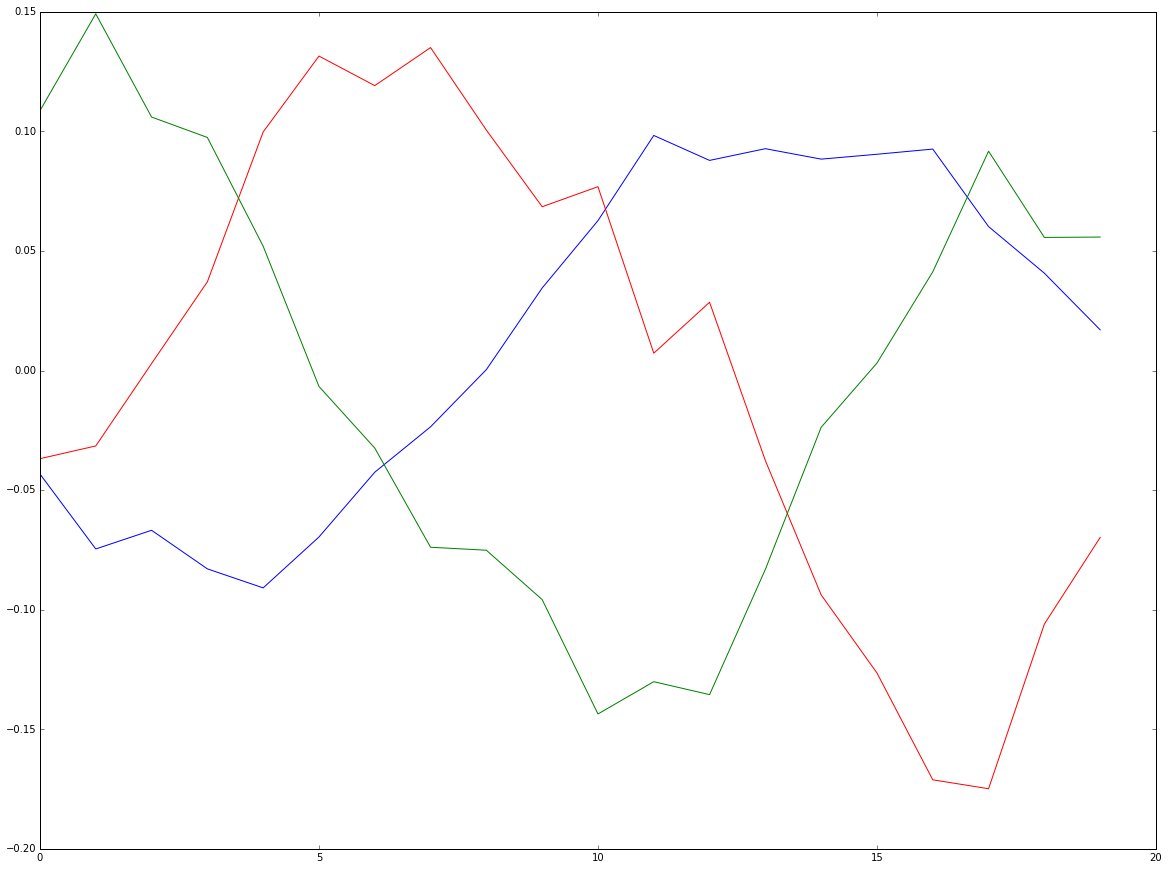

In [22]:
# Okay, we have our test data, let's run our experiment.
# Sine waves, here we come?

run_exp(test_seq, 100, 3, 20)

last delta is 0.0
iters was 38


array([[-0.05120734, -0.00814747,  0.01585809,  0.03525597,  0.11071055,
         0.06462417,  0.02130033,  0.06481807, -0.03464692, -0.0304534 ,
        -0.06177424, -0.07992006, -0.02360002, -0.06489257, -0.03674338,
         0.01873199, -0.05909837, -0.00866143,  0.00137933, -0.03890986,
         0.11987321,  0.04844495,  0.06722344,  0.07925833, -0.05746594,
         0.03878612, -0.05574248, -0.02498886,  0.02951386, -0.02022243,
         0.03924653,  0.09551915, -0.00240036,  0.09921226, -0.00976219,
         0.01486514,  0.03045962, -0.01969142,  0.11079815,  0.0705577 ],
       [-0.01251077, -0.04034922, -0.04104768, -0.04875035, -0.07002648,
        -0.0238912 , -0.00867801,  0.01004061,  0.04842649,  0.06671723,
         0.11554475,  0.0966119 ,  0.07439031,  0.07098376,  0.05819987,
         0.01590779,  0.01505008, -0.04637111, -0.03999966, -0.0937658 ,
        -0.13066672, -0.11150018, -0.09201154, -0.07180242, -0.01892282,
        -0.00995293,  0.03765616,  0.03617355,  0.

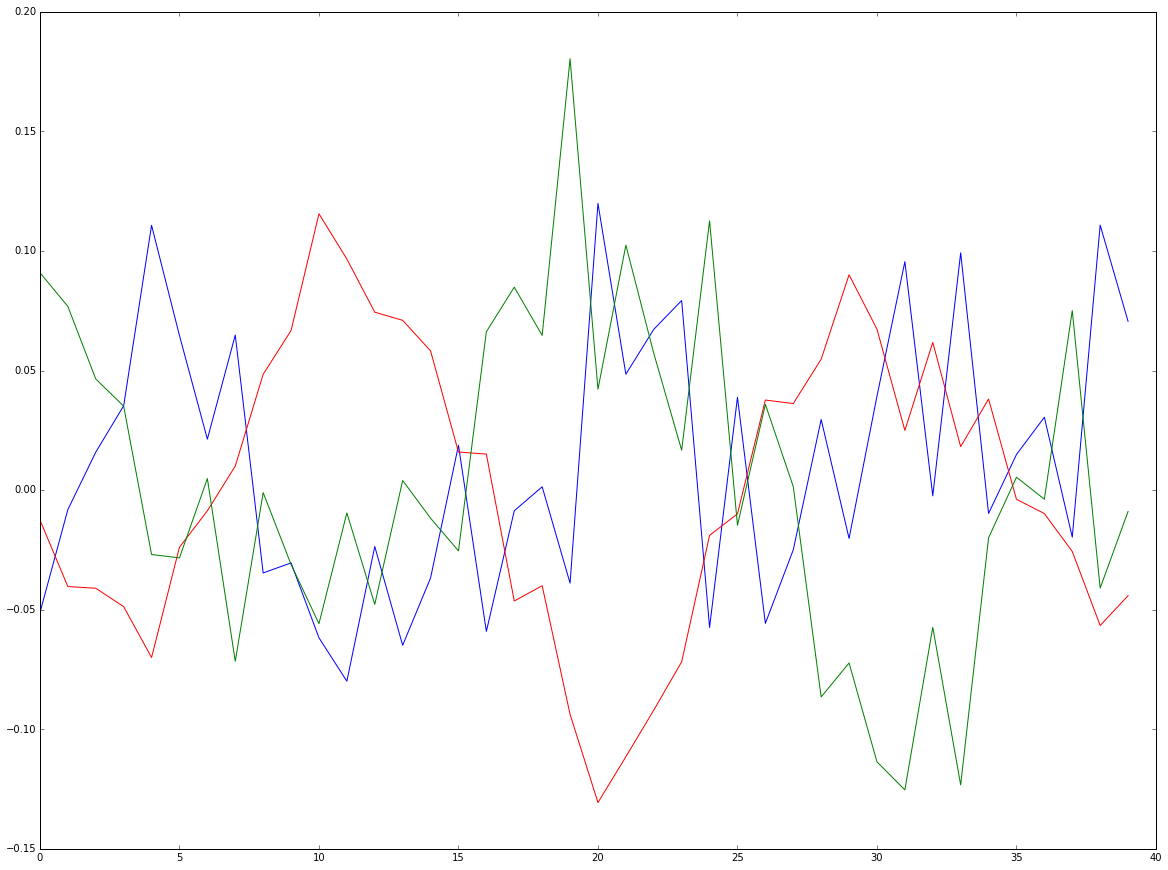

In [21]:
# And what if we change the window size?

run_exp(test_seq, 100, 3, 40)

last delta is 9.63920403841e-07
iters was 52


array([[-0.01109389,  0.05523971, -0.00281136, -0.01393762, -0.03170636,
         0.02045871,  0.06260878,  0.00566176, -0.04302638,  0.02721422,
        -0.27501663,  0.00896008, -0.01501558,  0.02322847, -0.01432485,
        -0.01940822,  0.04232757,  0.04487275, -0.04121853,  0.02396536],
       [ 0.02758553, -0.03666776,  0.00104082,  0.06243745,  0.0980045 ,
        -0.03343546, -0.15135095,  0.02863492,  0.12952336, -0.06958368,
         0.03613914,  0.01543793,  0.04630198, -0.04292385,  0.01194872,
         0.09910153, -0.08422645, -0.10772338,  0.10871381,  0.00983877],
       [-0.00893127, -0.0188671 ,  0.00675621, -0.03809331, -0.05223271,
         0.01406361,  0.07854473, -0.02738906, -0.06936543,  0.04037363,
         0.25760446, -0.01852881, -0.02199847,  0.02006378,  0.00889461,
        -0.0657589 ,  0.03852362,  0.05739488, -0.05182776, -0.0286371 ]])

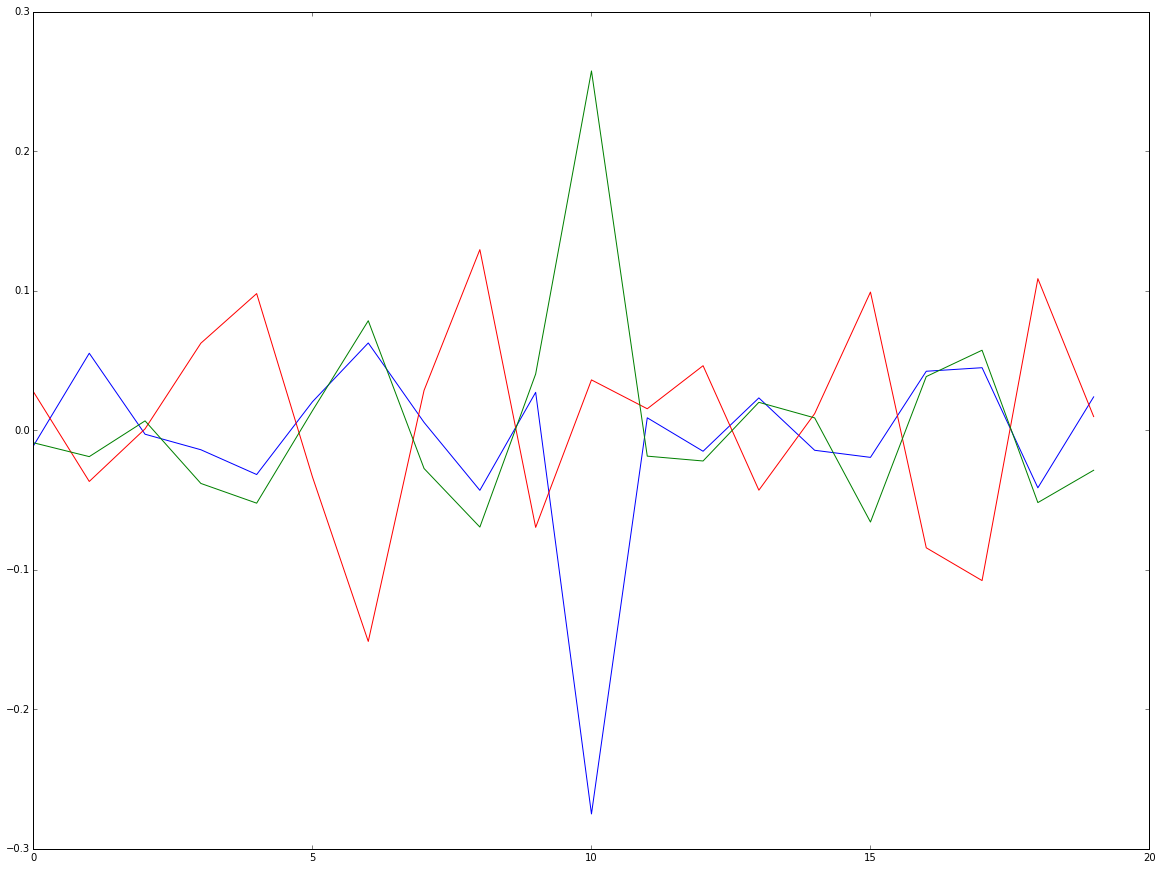

In [26]:
# Okay, so that one with the short windows looked almost like sine waves.  The one with
# the longer window size didn't.  Let's see what happens if we try the short window size on a
# longer sequence

long_test_seq = runsum(np.random.random((10000)) - 0.5, 0.9)
run_exp(long_test_seq, 100, 3, 20)

Well, *that* didn't look like a sine wave...  ...I wonder what's going on there.

last delta is 0.0
iters was 4


array([[ 0.49999799,  0.39999839,  0.2999988 ,  0.1999992 ,  0.0999996 ,
         0.        ,  0.0999996 ,  0.1999992 ,  0.2999988 ,  0.39999839,
         0.49999799,  0.59999759,  0.69999719,  0.79999679,  0.89999639,
         0.99999598,  0.89999639,  0.79999679,  0.69999719,  0.59999759,
         0.49999799],
       [ 0.49999799,  0.59999759,  0.69999719,  0.79999679,  0.89999639,
         0.99999598,  0.89999639,  0.79999679,  0.69999719,  0.59999759,
         0.49999799,  0.39999839,  0.2999988 ,  0.1999992 ,  0.0999996 ,
         0.        ,  0.0999996 ,  0.1999992 ,  0.2999988 ,  0.39999839,
         0.49999799]])

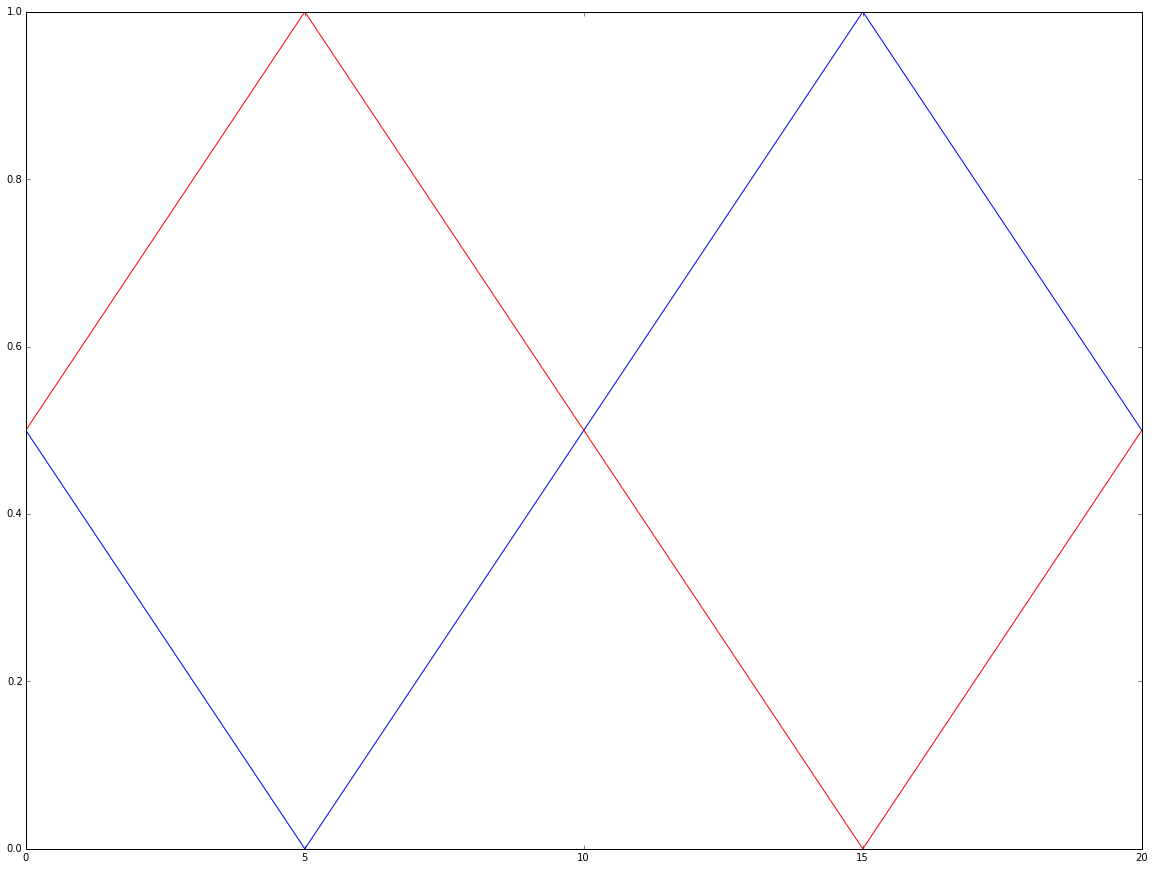

In [17]:
#Okay, let's see what it does when passed a square wave as input

# Prediction : the clusters will partition windows by the phase of the square wave
# and will integrate them, resulting in triangle shapes

square_wave_seq = np.array([1.0 * ((i % 20) < 10) for i in range(5000)])
run_exp(square_wave_seq, 100, 2, 21)

last delta is 0.0
iters was 4


array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.24999748,  0.49999496,  0.74999244,  0.99998992,
         0.99998992,  0.99998992,  0.99998992,  0.99998992,  0.99998992,
         0.99998992,  0.74999244,  0.49999496,  0.24999748,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.24999

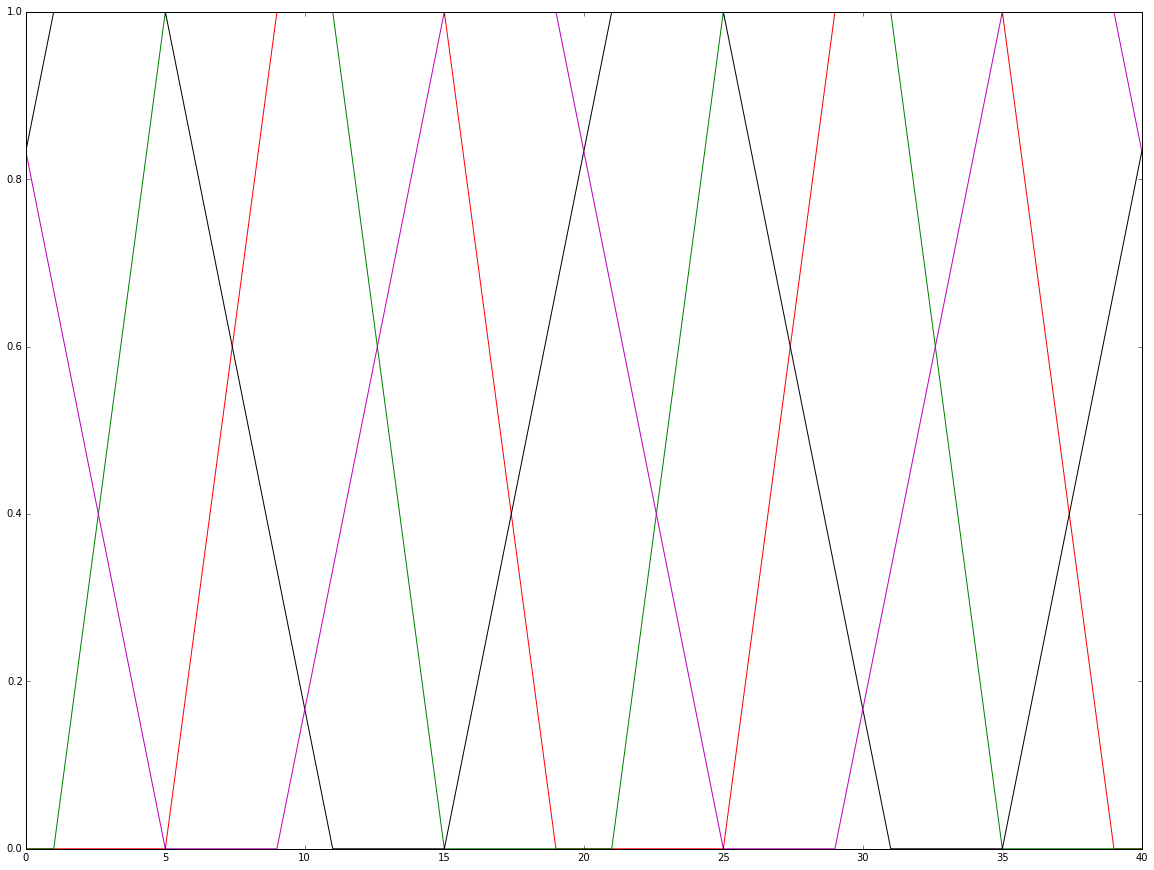

In [18]:
# Let's see how this works with a different window size

run_exp(square_wave_seq, 100, 5, 41)

last delta is 0.0
iters was 8


array([[  4.12806208e-01,   4.71407204e-01,   5.29771905e-01,
          5.88136606e-01,   6.46501308e-01,   7.04866009e-01,
          5.28590433e-01,   3.52314857e-01,   2.34876572e-01,
          1.17438286e-01,   0.00000000e+00,   1.76275576e-01,
          3.52787446e-01,   5.29299316e-01,   7.05811187e-01,
          8.82323057e-01,   8.23485767e-01,   7.64648477e-01,
          6.46973897e-01,   5.29299316e-01,   4.11624736e-01,
          4.70698321e-01,   5.29535611e-01,   5.88372901e-01,
          6.47210191e-01,   7.06047481e-01,   5.29535611e-01,
          3.53023740e-01,   2.35349160e-01,   1.17674580e-01,
          0.00000000e+00,   1.76275576e-01,   3.52787446e-01,
          5.29299316e-01,   7.05811187e-01,   8.82323057e-01,
          8.23485767e-01,   7.64412182e-01,   6.46501308e-01,
          5.28590433e-01,   4.10679559e-01],
       [  5.73391208e-04,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.42774411e-01,   2.85548821e-01,
          4.28323232e-01,

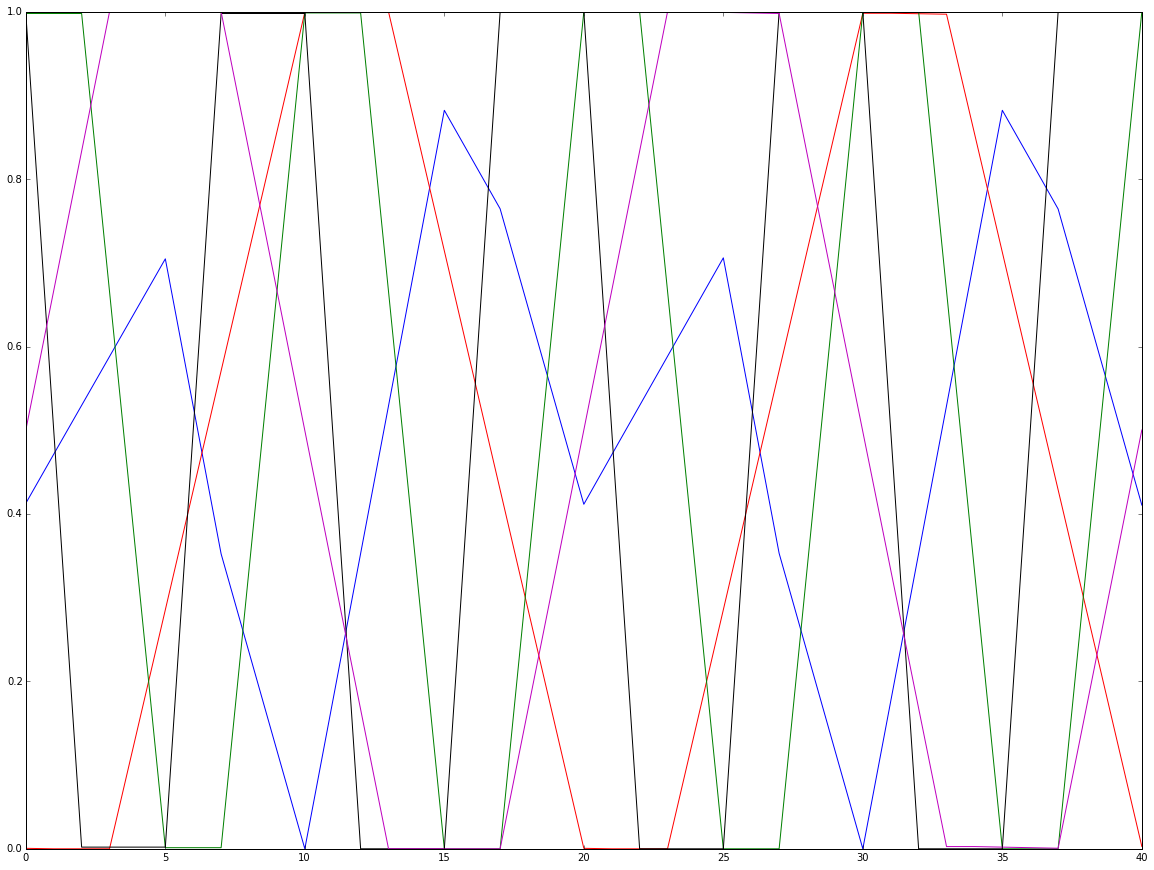

In [19]:
# What happens if we have two regions, each containing square waves of different frequencies?

hi_freq_square_wave_seq = np.array([1.0 * ((i % 10) < 5) for i in range(5000)])

run_exp(np.concatenate([square_wave_seq, hi_freq_square_wave_seq]), 100, 5, 41)

last delta is 0.0
iters was 13


array([[ 0.72661603,  0.79595518,  0.8158057 ,  0.78493336,  0.70525767,
         0.58173248,  0.42203798,  0.2361032 ,  0.03548866, -0.16733238,
        -0.35974951, -0.52979916, -0.66690846, -0.76255263, -0.81078496,
        -0.80860661, -0.75615302, -0.6566855 , -0.51638845, -0.34398487,
        -0.15019398,  0.05293525,  0.25277322,  0.43689497,  0.59385271,
         0.71388757,  0.78953636,  0.8160956 ,  0.79191396,  0.71849496,
         0.60040341,  0.44498169,  0.26189317,  0.06252139, -0.14073766,
        -0.33524633, -0.508911  , -0.65093405, -0.75248518, -0.80725042],
       [-0.70987784, -0.58358515, -0.42100795, -0.23225452, -0.02906063,
         0.17594011,  0.37000175,  0.54105847,  0.67847479,  0.77370684,
         0.82083355,  0.8169248 ,  0.76222362,  0.66013107,  0.51699477,
         0.34171424,  0.14518757, -0.06036616, -0.26216662, -0.44766682,
        -0.60533327, -0.72536303, -0.80029322, -0.82546507, -0.79931349,
        -0.72346447, -0.60263393, -0.44433454, -0.

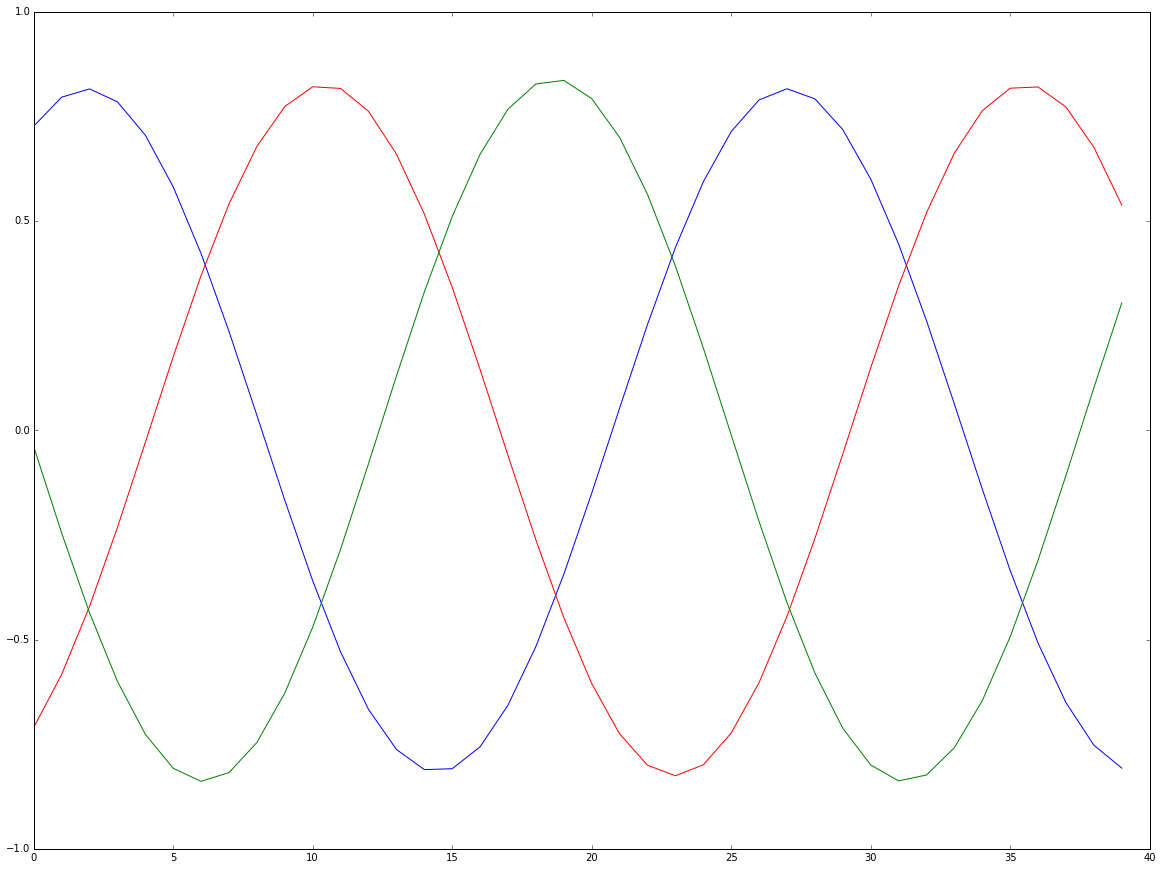

In [23]:
# For the heck of it, what if we actually feed through sine waves?

sine_wave_seq = [np.sin(0.25 * i) for i in range(10000)]
run_exp(sine_wave_seq, 100, 3, 40)

last delta is 2.3330401223e-05
iters was 100


array([[-0.8344936 , -0.73740907, -0.59447602, -0.41458133, -0.20890998,
         0.00975039,  0.22780452,  0.43169486,  0.60874452,  0.74794538],
       [ 0.55706633,  0.67719568,  0.75522029,  0.78628896,  0.76846998,
         0.70287127,  0.59357143,  0.44736619,  0.27334588,  0.08233026],
       [ 0.05538431, -0.14500794, -0.3363843 , -0.50684591, -0.6457943 ,
        -0.74459033, -0.79709133, -0.80003306, -0.75323261, -0.6595998 ]])

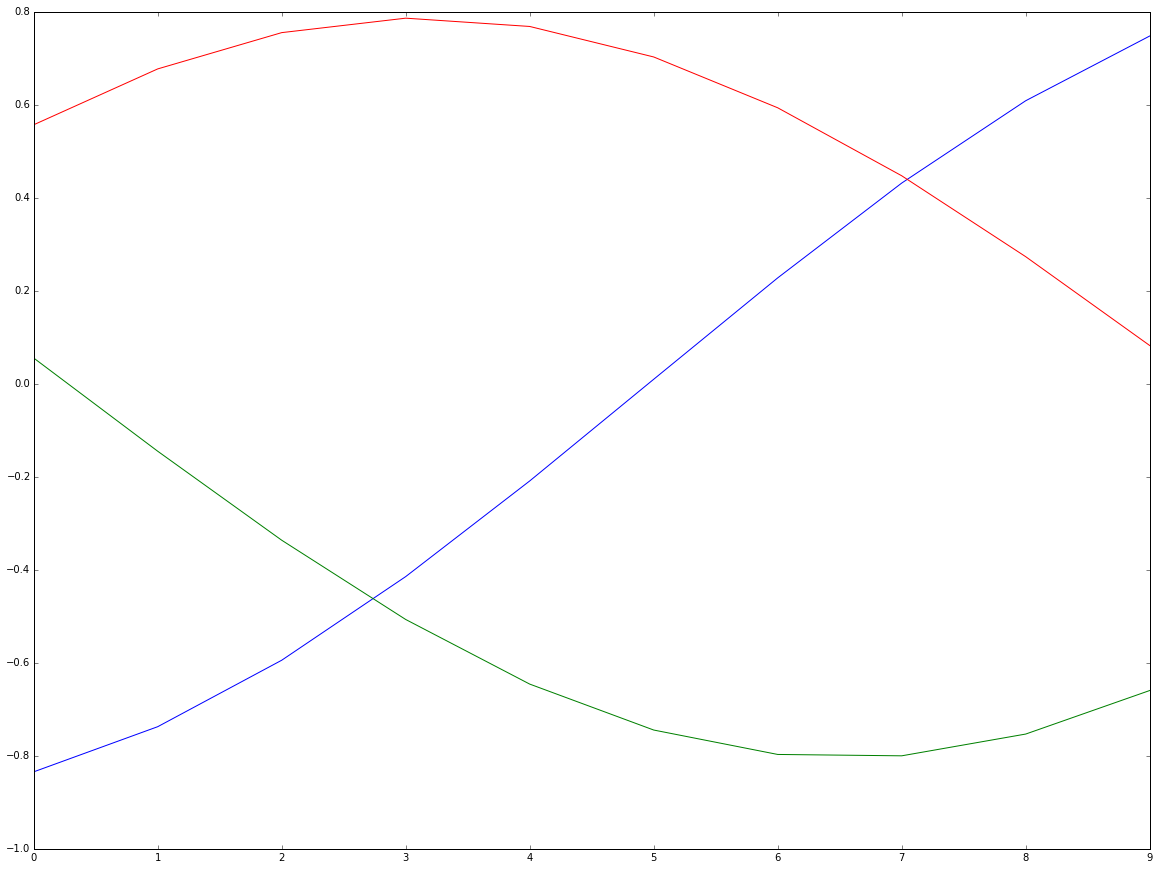

In [24]:
#Okay, what happens with a different window size?

run_exp(sine_wave_seq, 100, 3, 10)